In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torch torchvision efficientnet-pytorch
from efficientnet_pytorch import EfficientNet  # Corrected import statement

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f46a934b5fccb6084632bc406c3bc3a80ec57d4bfdb7efb3de8e1032aaa6ff18
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [3]:
def import_images(folder, target):
    images = []
    for item in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, item), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            images.append([img, target])
    return images

In [4]:
positive_test = np.array(import_images('/content/drive/MyDrive/Dataset/Kidney Stone/Dataset/Test/Kidney_stone',1),dtype=object)
negative_test = np.array(import_images('/content/drive/MyDrive/Dataset/Kidney Stone/Dataset/Test/Normal',0),dtype=object)
positive_train = np.array(import_images('/content/drive/MyDrive/Dataset/Kidney Stone/Dataset/Train/Kidney_stone',1),dtype=object)
negative_train = np.array(import_images('/content/drive/MyDrive/Dataset/Kidney Stone/Dataset/Train/Normal',0),dtype=object)
# 'dtype=object' for variable length

In [5]:
positive = np.concatenate([positive_train, positive_test])
negative = np.concatenate([negative_train, negative_test])

<ipython-input-6-9f247f314fe5>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,10,i+1)


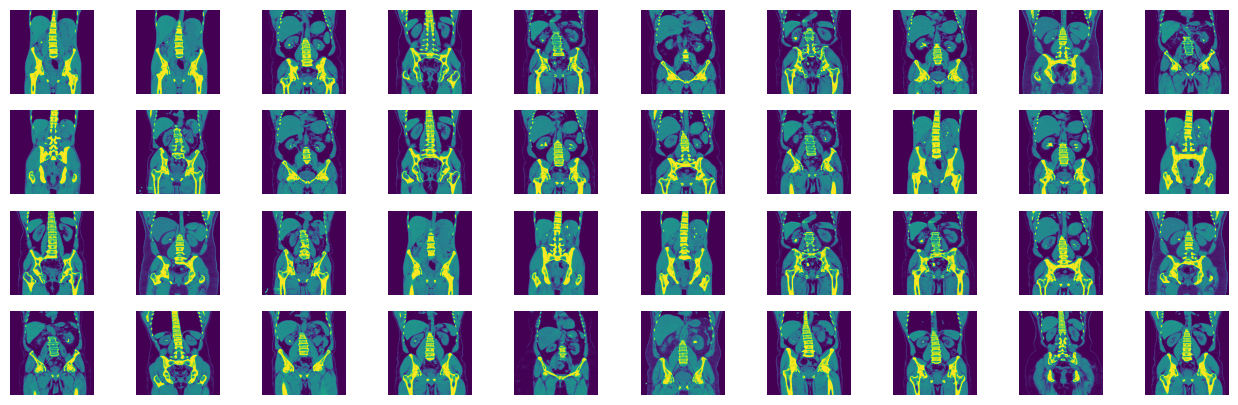

<ipython-input-6-9f247f314fe5>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,10,i+1)


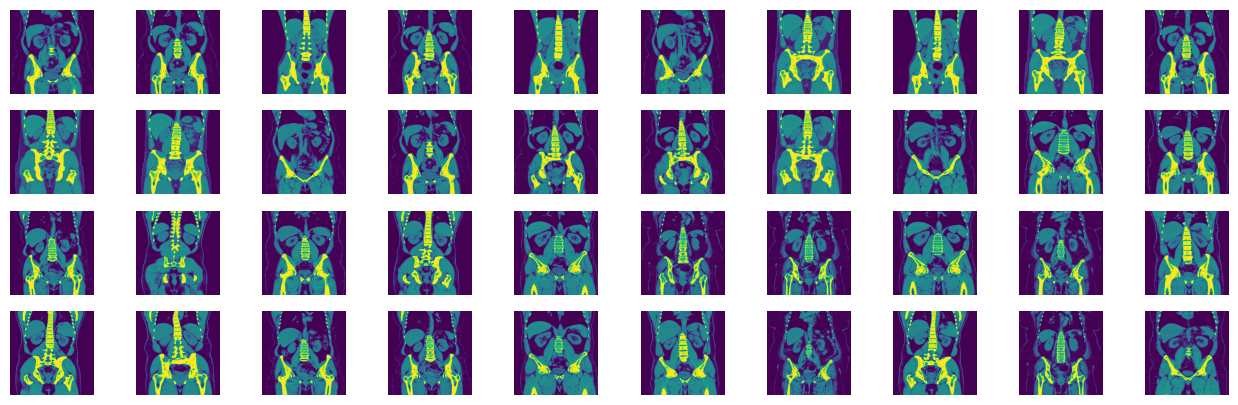

In [6]:
#Plotting samples
plt.figure(figsize=(16,5))
plt.title('Kidney Stone')
for i in range(0,40):
    plt.subplot(4,10,i+1)
    plt.imshow(positive[i][0])
    plt.axis('off')
plt.show()
plt.figure(figsize=(16,5))
plt.title('Normal')
for i in range(0,40):
    plt.subplot(4,10,i+1)
    plt.imshow(negative[i][0])
    plt.axis('off')
plt.show()

In [7]:
#Joining all the dataset together
full_data = np.concatenate([positive, negative])
#Performing the dataset splitting into training and test set
len(full_data[0])
full_data_array = np.array(full_data)
y = full_data_array[:, 1]
training_data, test_dataset = train_test_split(full_data, test_size = 0.20, stratify=y, random_state=55)
#Extracting validation dataset from the training data
full_data_array = np.array(training_data)
y = full_data_array[:, 1]
training_dataset, val_dataset = train_test_split(training_data, test_size = 0.25, stratify=y, random_state=100)

In [8]:
"""Function to separate the dataset into images and label puting the images in array called features and labels into
array called label"""

def split_data(main_data):
    features = []
    label = []
    for x,y in main_data:
        features.append(x)
        label.append(y)
    return np.array(features), np.array(label)

In [9]:
#Extract validation images and labels
training_images, training_labels = split_data(training_dataset)
# Normalize images
training_images = np.array(training_images, dtype="float") / 255.0

(1079, 224, 224)
(1079,)


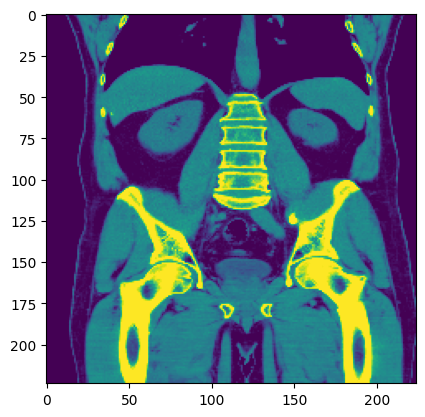

Encoded as 0
0    605
1    474
dtype: int64


In [10]:
#The shape of the datasets
print(training_images.shape)
print(training_labels.shape)

#Plotting an image from training images
plt.imshow(training_images[0])
plt.show()
print("Encoded as",training_labels[0])
print(pd.Series(training_labels).value_counts())

In [11]:
#Extract validation images and labels
val_images, val_labels = split_data(val_dataset)
# Normalize images
val_images = np.array(val_images, dtype="float") / 255.0
#Defining Image Data Generator for image augmentation

(360, 224, 224)
(360,)


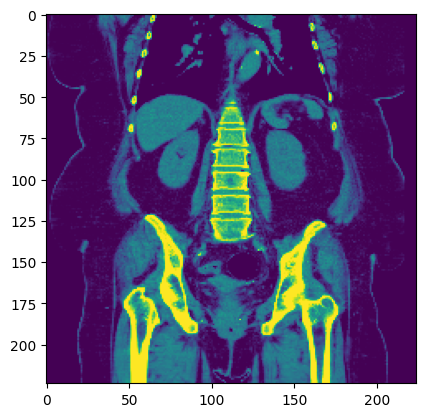

Encoded as 0
0    202
1    158
dtype: int64


In [12]:
#The shape of the datasets
print(val_images.shape)
print(val_labels.shape)

#Plotting an image from validation images
plt.imshow(val_images[0])
plt.show()
print("Encoded as",val_labels[0])
print(pd.Series(val_labels).value_counts())

In [13]:
#Extract validation images and labels
test_images, test_labels = split_data(test_dataset)
# Normalize images
test_images = np.array(test_images, dtype="float") / 255.0

(360, 224, 224)
(360,)


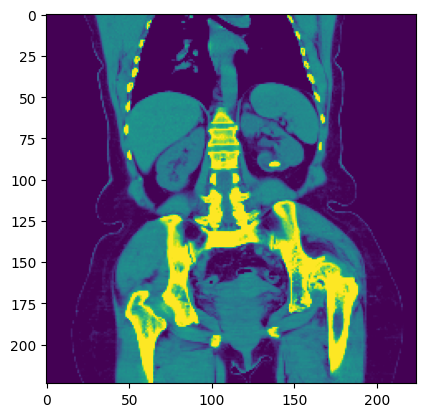

Encoded as 1
0    202
1    158
dtype: int64


In [14]:
#The shape of the datasets
print(test_images.shape)
print(test_labels.shape)

#Plotting an image from test images
plt.imshow(test_images[0])
plt.show()
print("Encoded as",test_labels[0])
print(pd.Series(test_labels).value_counts())

In [15]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.astype(np.uint8)

        if self.transform:
            image = self.transform(image)

        return image, label

In [16]:
# Define transformations for data augmentation and normalization
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# Create custom datasets
train_dataset = CustomDataset(training_images, training_labels, transform=train_transform)
test_dataset = CustomDataset(test_images, test_labels, transform=test_transform)
val_dataset = CustomDataset(val_images, val_labels, transform=test_transform)

# Create dataloaders
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Creating Custom Model

In [ ]:
best_val_loss = float(0.3306)
best_val_accuracy = float(0.9083)

In [17]:
# Define the model
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes, in_channels=1):
        super(EfficientNetModel, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b7', in_channels=in_channels)
        self.fc = nn.Linear(1000, num_classes)  # Adjust the number of output classes

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

# Create an instance of the model
model = EfficientNetModel(num_classes=2, in_channels=1)  # 2 classes: benign and malignant

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000033)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:01<00:00, 220MB/s]


Loaded pretrained weights for efficientnet-b7


EfficientNetModel(
  (backbone): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSa

In [ ]:
# Training loop
num_epochs = 150 # total epochs = 150
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    # Save the model with the best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print('Saving loss model')
        torch.save(model, '/content/drive/MyDrive/Dataset/Kidney Stone/loss_model.pt')
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print('Saving accuracy model')
        torch.save(model, '/content/drive/MyDrive/Dataset/Kidney Stone/accuracy_model.pt')

Epoch [1/150], Train Loss: 0.6969, Train Acc: 0.5839, Val Loss: 0.8964, Val Acc: 0.4389
Epoch [2/150], Train Loss: 0.6213, Train Acc: 0.6534, Val Loss: 0.6871, Val Acc: 0.5611
Epoch [3/150], Train Loss: 0.5642, Train Acc: 0.7025, Val Loss: 0.8156, Val Acc: 0.4389
Epoch [4/150], Train Loss: 0.4176, Train Acc: 0.8230, Val Loss: 0.8610, Val Acc: 0.4389
Epoch [5/150], Train Loss: 0.3811, Train Acc: 0.8387, Val Loss: 0.7774, Val Acc: 0.4389
Epoch [6/150], Train Loss: 0.3056, Train Acc: 0.8758, Val Loss: 0.9439, Val Acc: 0.4389
Epoch [7/150], Train Loss: 0.3346, Train Acc: 0.8591, Val Loss: 0.9304, Val Acc: 0.4444
Epoch [8/150], Train Loss: 0.2965, Train Acc: 0.8786, Val Loss: 0.7144, Val Acc: 0.4972
Epoch [9/150], Train Loss: 0.2738, Train Acc: 0.8897, Val Loss: 0.4673, Val Acc: 0.8000
Epoch [10/150], Train Loss: 0.2934, Train Acc: 0.8869, Val Loss: 0.3801, Val Acc: 0.8444
Epoch [11/150], Train Loss: 0.2322, Train Acc: 0.9120, Val Loss: 0.3289, Val Acc: 0.8833
Saving loss model
Epoch [12/15

In [19]:
# Testing loop
model = torch.load('/content/drive/MyDrive/Dataset/Kidney Stone/accuracy_model.pt', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total
print(f'Test Accuracy: {test_acc:.4f}')

KeyboardInterrupt: 

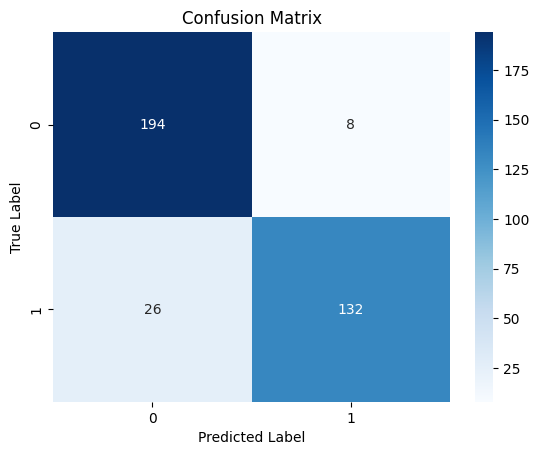

array([[194,   8],
       [ 26, 132]])

In [18]:
# prompt: plot the confusion matrix for test data

# Get predictions for test data
y_pred = []
y_true = []
model = torch.load('/content/drive/MyDrive/Dataset/Kidney Stone/accuracy_model.pt', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
cm

In [19]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       202
           1       0.94      0.84      0.89       158

    accuracy                           0.91       360
   macro avg       0.91      0.90      0.90       360
weighted avg       0.91      0.91      0.90       360



In [7]:
import numpy as np
import os
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torch torchvision efficientnet-pytorch
from efficientnet_pytorch import EfficientNet  # Corrected import statement

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b7')
        self.fc = nn.Linear(1000, num_classes)  # Adjust the number of output classes

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

# Create an instance of the model
model = EfficientNetModel(num_classes=2)  # 2 classes: benign and malignant

def import_images(path):
    images = []
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        images.append(img)
    return images
def func(path):
  images = np.array(import_images(path))

  images = np.array(images, dtype='float') / 255.0

  image = torch.from_numpy(images).unsqueeze(0).float()

  class CustomDataset(Dataset):
      def __init__(self, images, transform=None):
          self.images = images
          self.transform = transform

      def __len__(self):
          return len(self.images)

      def __getitem__(self, idx):
          image = self.images[idx]

          image = image.astype(np.uint8)

          if self.transform:
              image = self.transform(image)

          return image
  # Define transformations for data augmentation and normalization
  test_transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.ToTensor(),
  ])

  # Create custom datasets
  test_dataset = CustomDataset(images, transform=test_transform)

  # Create dataloaders
  batch_size = 1
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  y_pred = []
  model = torch.load('/content/drive/MyDrive/Dataset/Kidney Stone/accuracy_model.pt', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  model.eval()
  with torch.no_grad():
      for images in test_loader:
          images = images.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          y_pred.extend(predicted.cpu().numpy())

  # 'predictions' now contains the predicted classes for each image in the dataset
  # print("Predicted classes:", y_pred)
  return y_pred[0]

Loaded pretrained weights for efficientnet-b7


In [8]:
good_morning = func('/content/purba.png')
print(good_morning)

1
